 # LAB 7 MOS:  Simulación del Sistema de Torniquetes con SimPy

- Samuel Augusto Hernandez 202213772
- Tomas Alberto Rodriguez 2022128686

## Definición

La Universidad de los Andes estima un crecimiento del 28\% en la población estudiantil para el año 2025, lo que genera inquietudes sobre si la infraestructura de torniquetes del edificio SD (3 de entrada, 3 de salida; incluyendo 1 de entrada y 1 de salida con QR) podrá soportar la demanda. Especificaciones operativas:

- Tiempo de pase torniquete: $5 \pm 2$ s

- Preparación de carnet: $10 \pm 2$ s

- Lectura QR: $20 \pm 2$ s

## **Modelo Conceptual del Sistema**

### **Variables**

- Cola por torniquete: $Q_i =$ número de personas esperando en la cola del torniquete $i$

- Estado del torniquete: $S_i \in \{\text{ocupado}, \text{libre}\}$

- Persona: $m \in \{\text{carnet}, \text{QR}\},\ d \in \{\text{in}, \text{out}\},\ t =$ instante de llegada

### **Parámetros**

- Torniquetes: 3 de entrada y 3 de salida (1 para QR de cada uno)

- Tiempo de preparación de carnet: $10 \pm 2$ s

- Tiempo de lectura de QR: $20 \pm 2$ s

- Tiempo para pasar por el torniquete:  $5 \pm 2$ s

- Distribución del tiempo de llegada: modelada a partir de datos históricos

- Asignación de colas: 
  - Si $m = \text{QR}$, va al torniquete QR correspondiente
  - Si $m = \text{carnet}$, va al torniquete con menor longitud de cola


### **Métricas de Desempeño**

- Tiempo en cola: 
  $$
  T_{\text{cola}} = T_{\text{salida\_de\_cola}} - T_{\text{llegada}}
  $$

- Promedio de longitud de cola


### **Eventos**

#### **Llegada al edificio:**

##### **Acciones**

- Seleccionar torniquete i segun regla
- Si esta libre, hacer "Inicio de servicio"
- Si esta ocupado, entrar a la cola

#### **Inicio de servicio:**

##### **Acciones**

- Esperar tiempo segun caracteristicas
- Hacer "Fin de servicio"

#### **Fin de servicio:**

##### **Acciones**

- Registrar salida de persona
- Actualizar la cola del torniquete
- Si la cola pasa a estar vacia, actualizar su estado a libre
- Si la cola aun tiene personas, extraer una persona y hacer "Inicio de servicio"


## Instalacion  e importacion de librerias

In [27]:
!pip install fitter
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install simpy

In [55]:
import pandas as pd
import numpy as np
from fitter import Fitter, get_common_distributions
import matplotlib.pyplot as plt
from scipy.stats import lognorm
import simpy
import random
import seaborn as sns
from tqdm import tqdm

## Carga de datos

In [29]:
# -------- parámetros --------
file_path = "SD Feb-May 2019.xlsx"           
sheets     = ["Feb-Mar", "Abr-May"] 

# -------- lectura --------
df_list = [pd.read_excel(file_path, sheet_name=s, engine="openpyxl") for s in sheets]
df = pd.concat(df_list)

df.index = pd.to_datetime(df['fecha_completa'], format='Y-%m-%d %H:%M:%S')

## Fase 1 Modelado de llegadas y salidas

In [30]:
df_filtered = (
        df.drop(columns=["PORTERIA", "RESULTADO_EVENTO", "ROL"])
        .query("MODO_ACCESO == 'Peatonal'")
        .drop(columns=["MODO_ACCESO"])
)
df_filtered["TIPO_ACCESO"] = df_filtered["TIPO_ACCESO"].str.strip()
df_filtered["DIA"] = pd.to_numeric(df_filtered["DIA"])
df_filtered.set_index(pd.to_datetime(df_filtered.index), inplace=True)

df_filtered.drop_duplicates(inplace=True)

df_filtered['day_of_week'] = df_filtered.index.day_name()

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_filtered['day_of_week'] = pd.Categorical(df_filtered['day_of_week'], categories=day_order, ordered=True)

df_filtered['week'] = df_filtered.index.isocalendar().week

df_filtered['time'] = df_filtered.index.time

# Separate Entries and Exits
df_in = df_filtered[df_filtered["TIPO_ACCESO"] == "IN"]
df_out = df_filtered[df_filtered["TIPO_ACCESO"] == "OUT"]

Por dia del mes

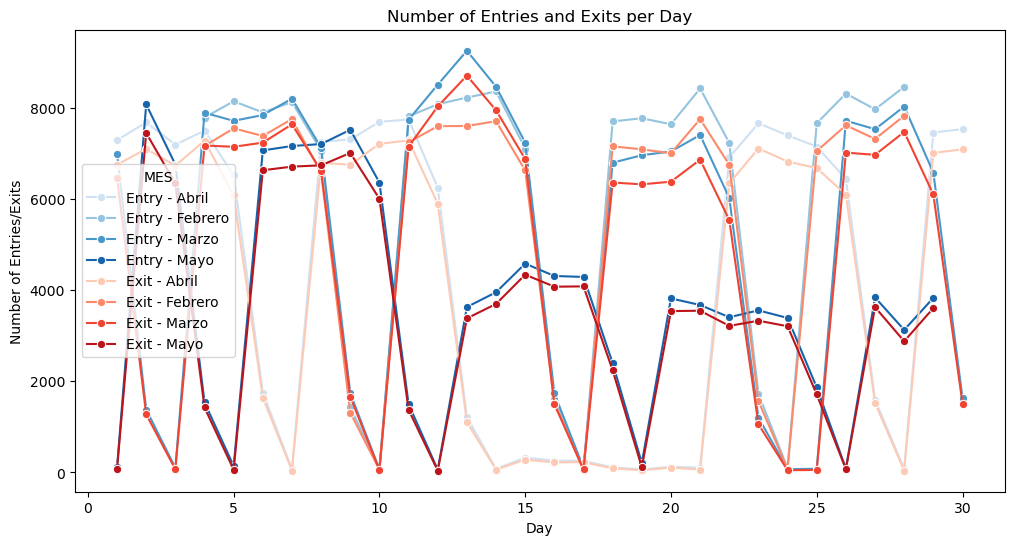

In [31]:
df_in_day = df_in.groupby(["MES", "DIA"]).size().reset_index(name="Entries")
df_out_day = df_out.groupby(["MES", "DIA"]).size().reset_index(name="Exits")

df_in_day['DAY'] = df_in_day['DIA']
df_out_day['DAY'] = df_out_day['DIA']

df_in_day['MES'] = "Entry - " + df_in_day['MES']
df_out_day['MES'] = "Exit - " + df_out_day['MES']

df_in_day = df_in_day.drop(columns=["DIA"])
df_out_day = df_out_day.drop(columns=["DIA"])

# Plotting
palette = {"Entries": sns.color_palette("Blues", 4), "Exits": sns.color_palette("Reds", 4)}
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the entries it should plot the entries per day and diferentiate by a hue applied to the month
sns.lineplot(data=df_in_day, x="DAY", y="Entries", hue="MES", marker="o", palette=palette['Entries'], ax=ax)

# Plot the exits it should plot the exits per day and diferentiate by a hue applied to the month

sns.lineplot(data=df_out_day, x="DAY", y="Exits", hue="MES", marker="o", palette=palette['Exits'], ax=ax)

# Set the title of the plot

plt.title("Number of Entries and Exits per Day")

# Set the x-axis label
plt.xlabel("Day")

# Set the y-axis label
plt.ylabel("Number of Entries/Exits")
plt.show()

Por dia de la semana en intervalos de 5 minutos

/tmp/ipykernel_4163/937845871.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_in_day = df_in[df_in['day_of_week'] == day].set_index('fecha_completa').resample('5T').size().reset_index(name='Entries')
/tmp/ipykernel_4163/937845871.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_out_day = df_out[df_out['day_of_week'] == day].set_index('fecha_completa').resample('5T').size().reset_index(name='Exits')
/tmp/ipykernel_4163/937845871.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_in_day = df_in[df_in['day_of_week'] == day].set_index('fecha_completa').resample('5T').size().reset_index(name='Entries')
/tmp/ipykernel_4163/937845871.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_out_day = df_out[df_out['day_of_week'] == day].set_index('fecha_compl

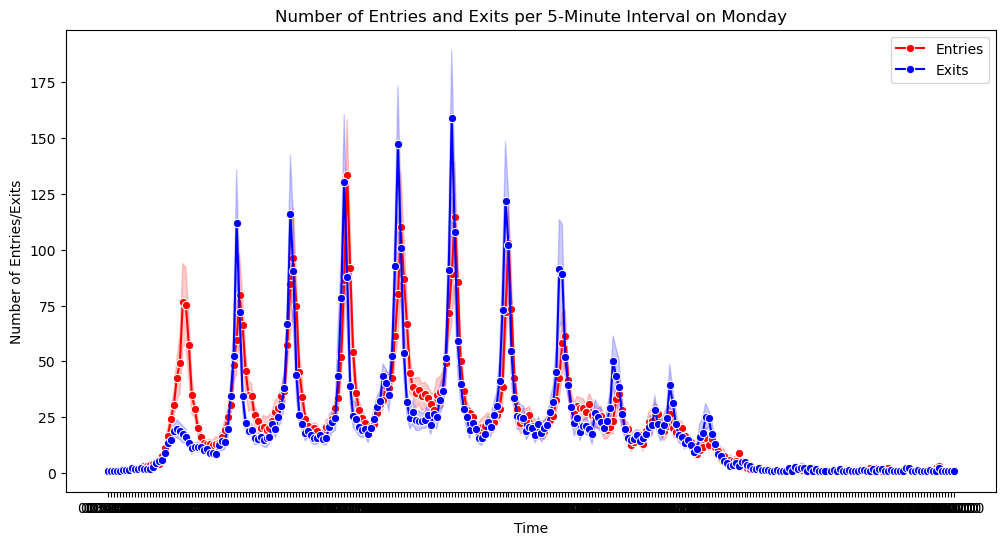

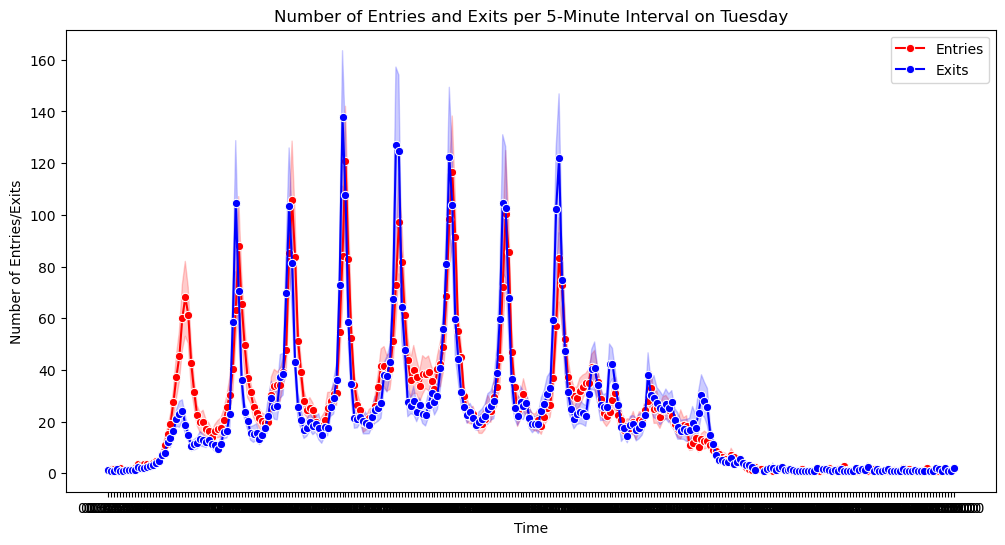

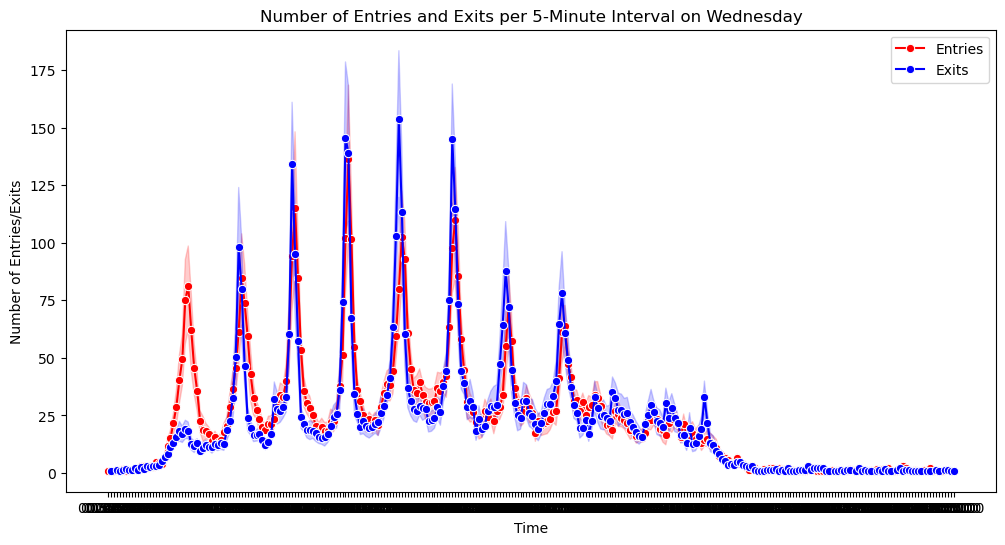

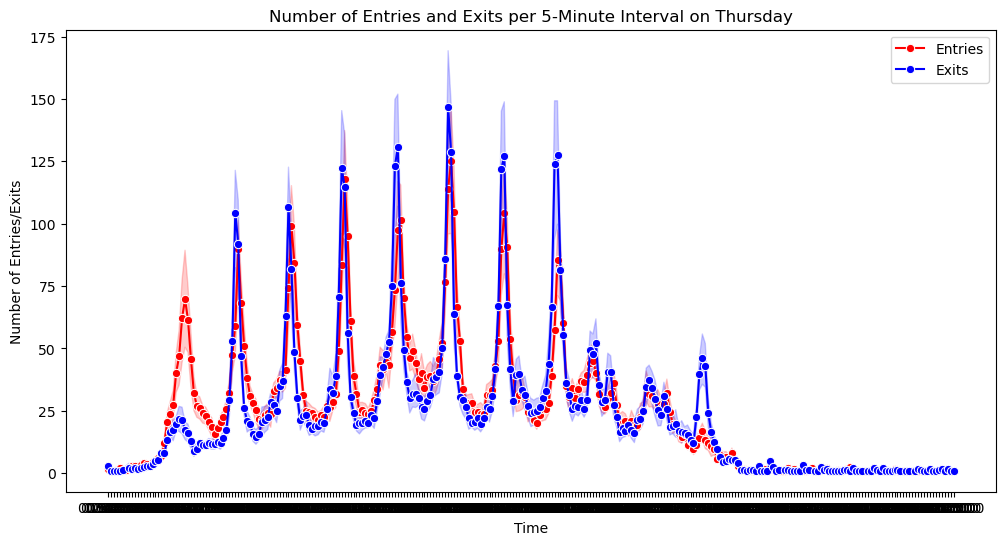

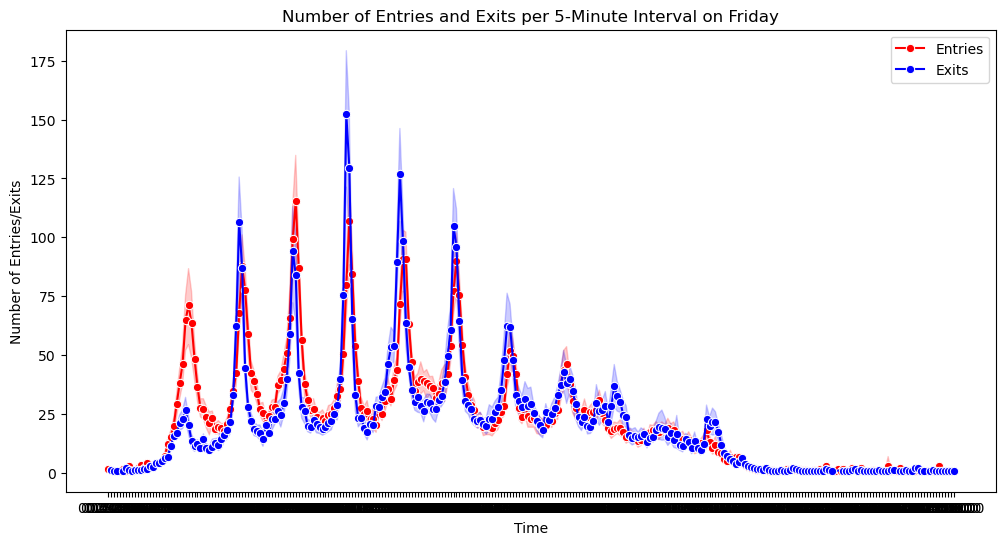

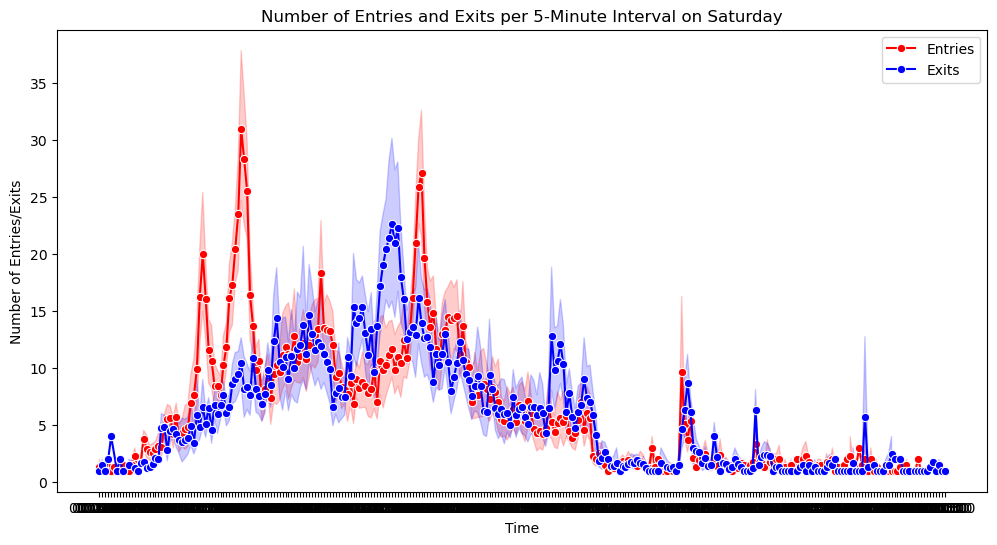

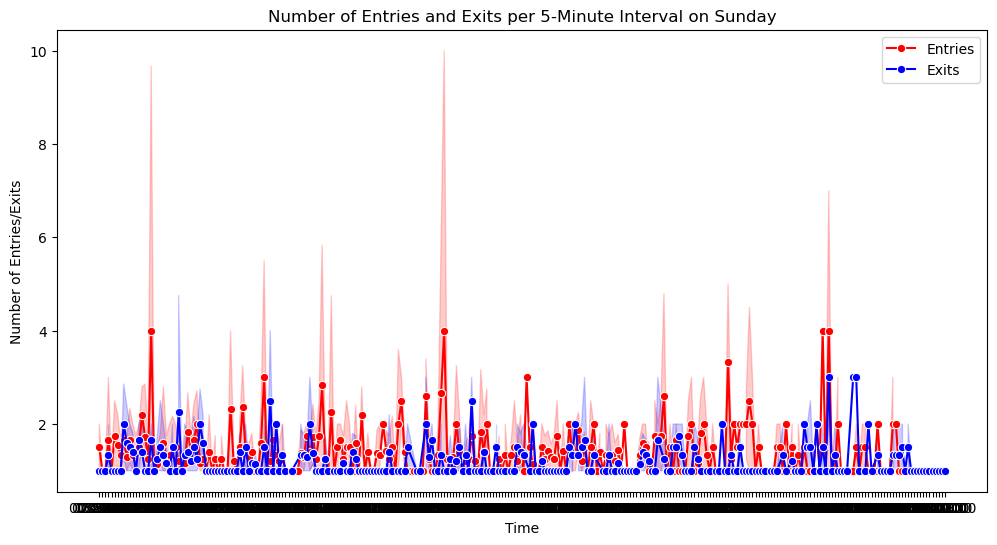

In [32]:
# Initialize dictionaries to hold DataFrames
df_in_5min = {}
df_out_5min = {}

# Group by 5-minute intervals for each day of the week
for day in df_in['day_of_week'].cat.categories:
        df_in_day = df_in[df_in['day_of_week'] == day].set_index('fecha_completa').resample('5T').size().reset_index(name='Entries')
        df_out_day = df_out[df_out['day_of_week'] == day].set_index('fecha_completa').resample('5T').size().reset_index(name='Exits')

        # Only keep non-zero entries
        df_in_day = df_in_day[df_in_day['Entries'] > 0]
        df_out_day = df_out_day[df_out_day['Exits'] > 0]

        df_in_day['time'] = df_in_day['fecha_completa'].dt.time.astype(str)
        df_out_day['time'] = df_out_day['fecha_completa'].dt.time.astype(str)

        df_in_day.set_index('time', inplace=True)
        df_out_day.set_index('time', inplace=True)

        df_in_5min[day] = df_in_day
        df_out_5min[day] = df_out_day

for day in df_in_5min.keys():
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot the entries per 5-minute interval
        sns.lineplot(data=df_in_5min[day], x=df_in_5min[day].index, y='Entries', marker='o', label='Entries', ax=ax, color='red')

        # Plot the exits per 5-minute interval
        sns.lineplot(data=df_out_5min[day], x=df_out_5min[day].index, y='Exits', marker='o', label='Exits', ax=ax, color='blue')

        # Set the title of the plot
        plt.title(f"Number of Entries and Exits per 5-Minute Interval on {day}")

        # Set the x-axis label
        plt.xlabel("Time")

        # Set the y-axis label
        plt.ylabel("Number of Entries/Exits")

        plt.legend()
        plt.show()

/tmp/ipykernel_4163/3497570491.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('1T')
/tmp/ipykernel_4163/3497570491.py:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('1T')
/tmp/ipykernel_4163/3497570491.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('1T')
/tmp/ipykernel_4163/3497570491.py:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('1T')
/tmp/ipykernel_4163/3497570491.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('1T')
/tmp/ipykernel_4163/3497570491.py:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('1T')
/tmp/ipykernel_4163/3497570491.py:13: FutureWarning: 'T' is depr

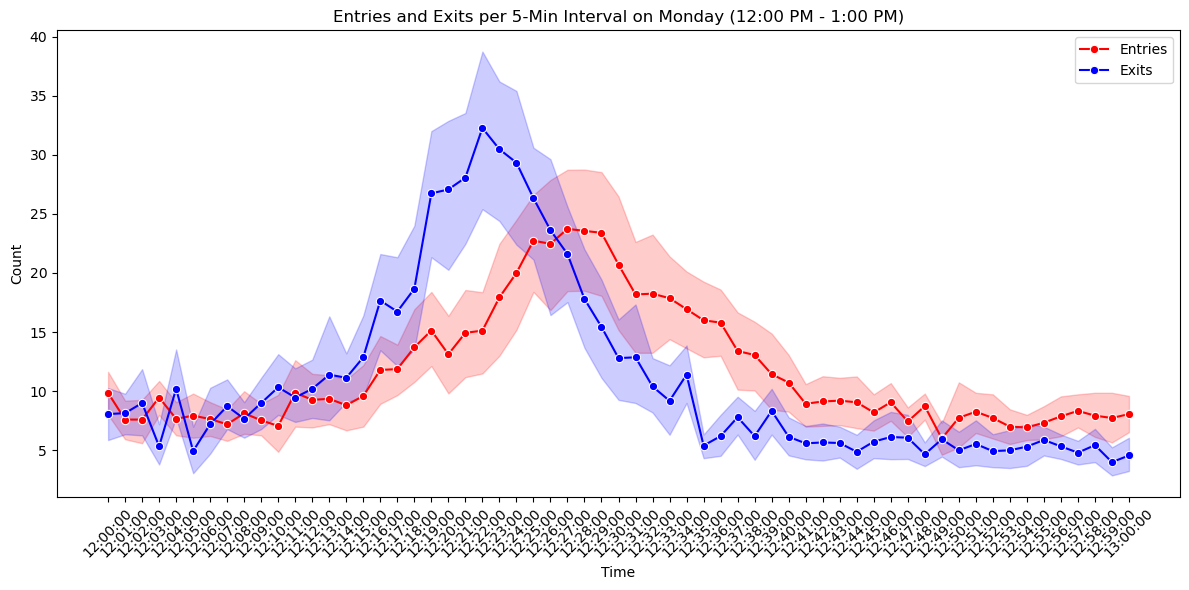

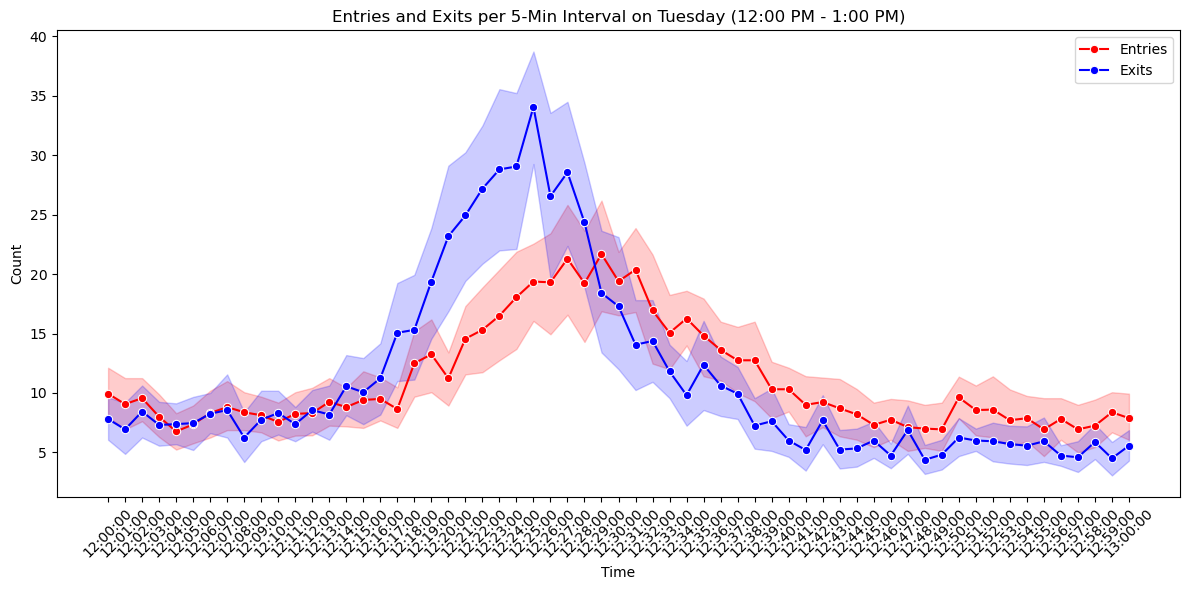

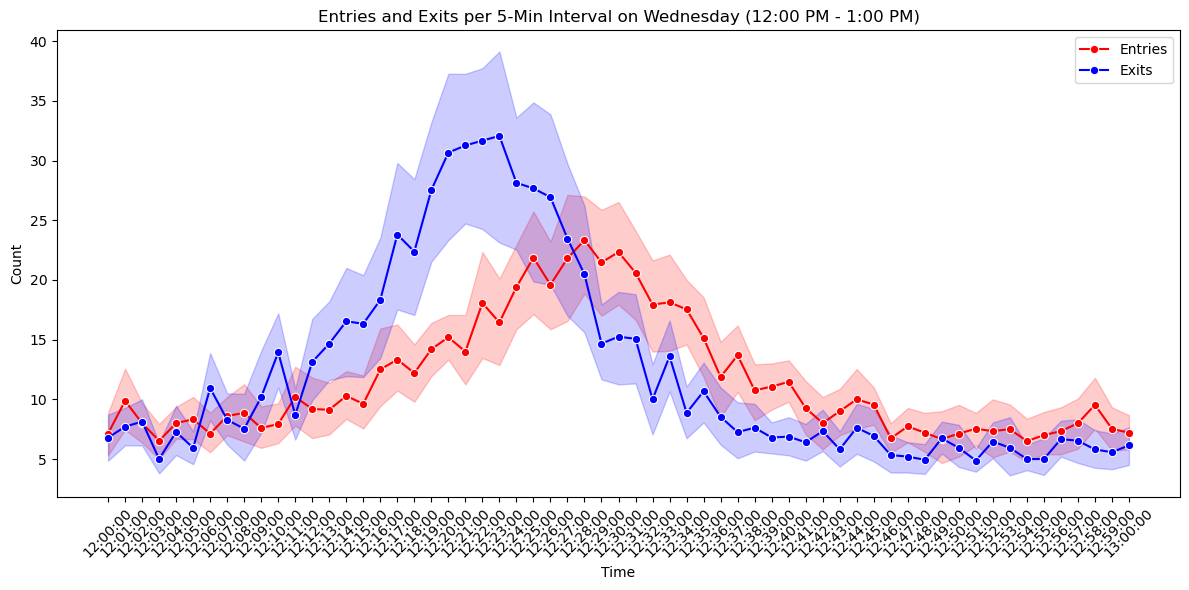

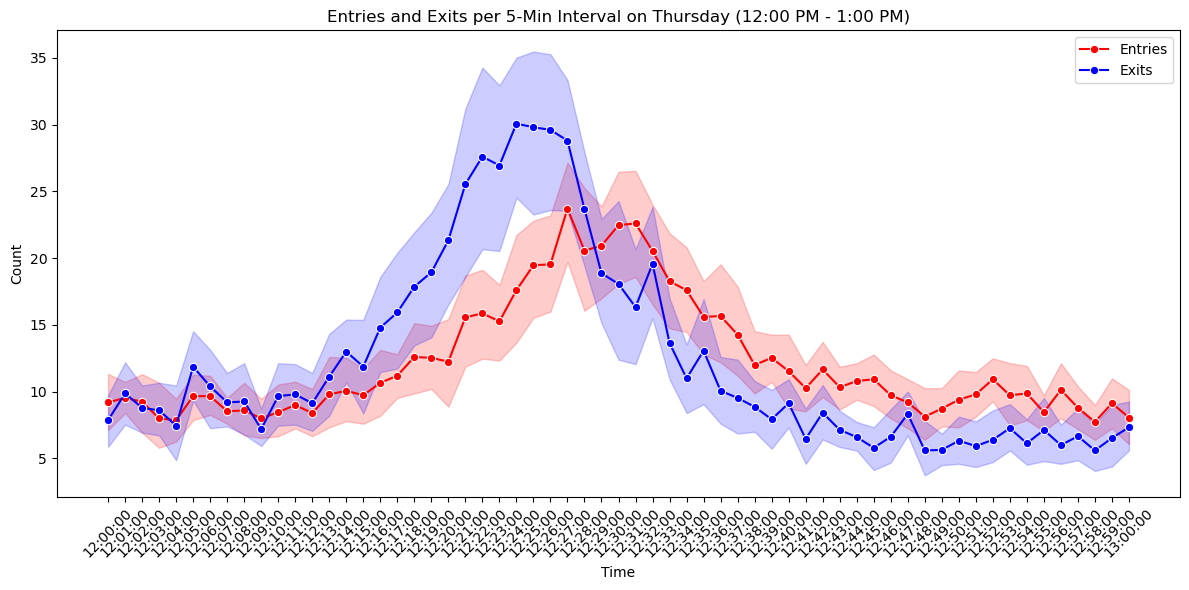

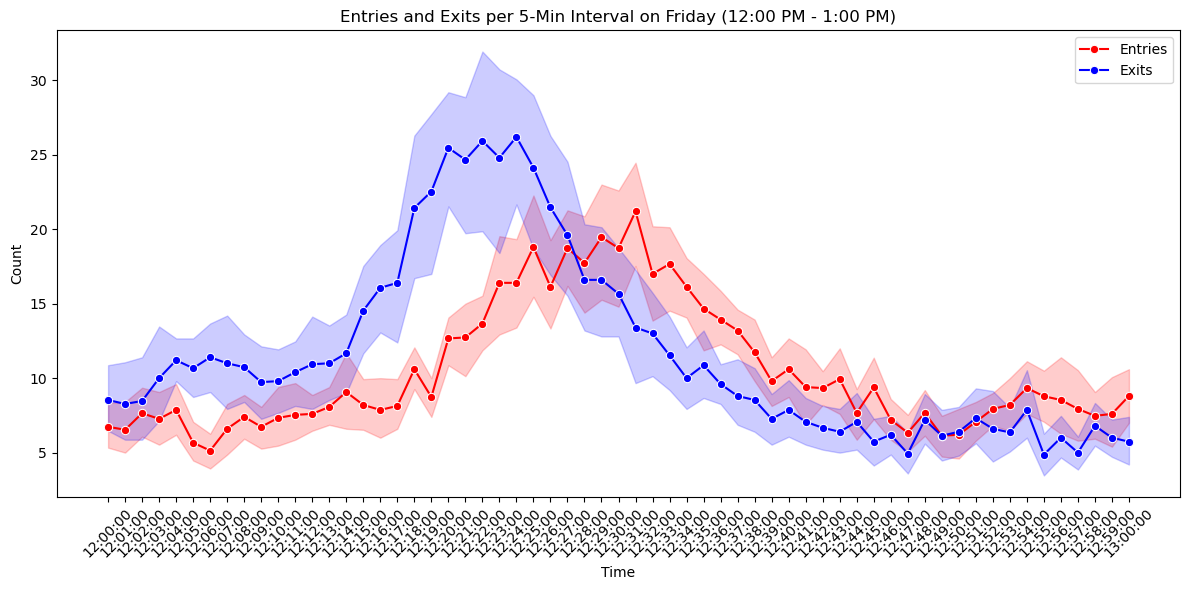

In [33]:
# Inicializar diccionarios
df_in_5min = {}
df_out_5min = {}

# Días a incluir (excluir sábado y domingo)
dias_validos = [d for d in df_in['day_of_week'].cat.categories if d not in ['Saturday', 'Sunday']]

# Agrupar por intervalos de 5 minutos por día de la semana
for day in dias_validos:
    df_in_day = (
        df_in[df_in['day_of_week'] == day]
        .set_index('fecha_completa')
        .resample('1T')
        .size()
        .reset_index(name='Entries')
    )
    df_out_day = (
        df_out[df_out['day_of_week'] == day]
        .set_index('fecha_completa')
        .resample('1T')
        .size()
        .reset_index(name='Exits')
    )

    # Filtrar entradas y salidas no nulas
    df_in_day = df_in_day[df_in_day['Entries'] > 0]
    df_out_day = df_out_day[df_out_day['Exits'] > 0]

    # Agregar columna de hora como string para indexar
    df_in_day['time'] = df_in_day['fecha_completa'].dt.time.astype(str)
    df_out_day['time'] = df_out_day['fecha_completa'].dt.time.astype(str)

    # Filtrar solo registros entre 12:00 y 13:00
    df_in_day = df_in_day[df_in_day['fecha_completa'].dt.time.between(pd.to_datetime("12:00").time(), pd.to_datetime("13:00").time())]
    df_out_day = df_out_day[df_out_day['fecha_completa'].dt.time.between(pd.to_datetime("12:00").time(), pd.to_datetime("13:00").time())]

    df_in_day.set_index('time', inplace=True)
    df_out_day.set_index('time', inplace=True)

    df_in_5min[day] = df_in_day
    df_out_5min[day] = df_out_day

# Graficar por cada día válido
for day in df_in_5min.keys():
    fig, ax = plt.subplots(figsize=(12, 6))
    
    sns.lineplot(data=df_in_5min[day], x=df_in_5min[day].index, y='Entries', marker='o', label='Entries', ax=ax, color='red')
    sns.lineplot(data=df_out_5min[day], x=df_out_5min[day].index, y='Exits', marker='o', label='Exits', ax=ax, color='blue')

    plt.title(f"Entries and Exits per 5-Min Interval on {day} (12:00 PM - 1:00 PM)")
    plt.xlabel("Time")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_4163/318176068.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  rango_tiempos = pd.date_range("12:00", "12:59", freq="1T").time
/tmp/ipykernel_4163/318176068.py:21: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('1T')
/tmp/ipykernel_4163/318176068.py:33: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('1T')
/tmp/ipykernel_4163/318176068.py:21: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('1T')
/tmp/ipykernel_4163/318176068.py:33: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('1T')
/tmp/ipykernel_4163/318176068.py:21: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('1T')
/tmp/ipykernel_4163/31

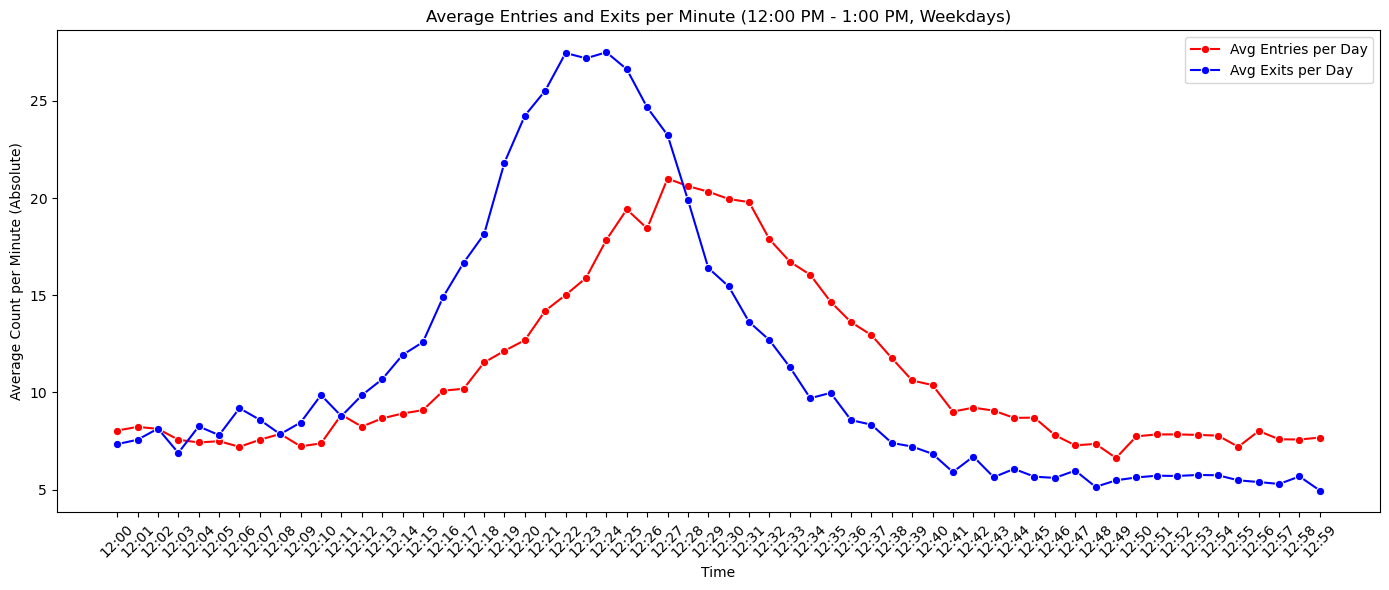

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Inicializar acumuladores
suma_entries = pd.Series(dtype=float)
suma_exits = pd.Series(dtype=float)

# Rango de tiempo esperado entre 12:00 y 13:00 en pasos de 1 minuto
rango_tiempos = pd.date_range("12:00", "12:59", freq="1T").time
rango_tiempos_str = [t.strftime("%H:%M:%S") for t in rango_tiempos]

# Días hábiles (excluyendo sábado y domingo)
dias_validos = [d for d in df_in['day_of_week'].cat.categories if d not in ['Saturday', 'Sunday']]

for day in dias_validos:
    # Entradas
    df_in_day = (
        df_in[df_in['day_of_week'] == day]
        .set_index('fecha_completa')
        .resample('1T')
        .size()
        .reset_index(name='Entries')
    )
    df_in_day = df_in_day[df_in_day['fecha_completa'].dt.time.between(pd.to_datetime("12:00").time(), pd.to_datetime("13:00").time())]
    df_in_day['time'] = df_in_day['fecha_completa'].dt.strftime('%H:%M:%S')
    df_in_day = df_in_day.groupby('time')['Entries'].sum()

    # Salidas
    df_out_day = (
        df_out[df_out['day_of_week'] == day]
        .set_index('fecha_completa')
        .resample('1T')
        .size()
        .reset_index(name='Exits')
    )
    df_out_day = df_out_day[df_out_day['fecha_completa'].dt.time.between(pd.to_datetime("12:00").time(), pd.to_datetime("13:00").time())]
    df_out_day['time'] = df_out_day['fecha_completa'].dt.strftime('%H:%M:%S')
    df_out_day = df_out_day.groupby('time')['Exits'].sum()

    # Rellenar con 0 donde falte tiempo
    entries = df_in_day.reindex(rango_tiempos_str, fill_value=0)
    exits = df_out_day.reindex(rango_tiempos_str, fill_value=0)

    # Acumular sumas
    suma_entries = suma_entries.add(entries, fill_value=0)
    suma_exits = suma_exits.add(exits, fill_value=0)

# Calcular la media (promedio por día)
n_dias = len(dias_validos)
promedio_entries = suma_entries / 80 if n_dias > 0 else suma_entries
promedio_exits = suma_exits / 80 if n_dias > 0 else suma_exits

# Crear DataFrame para graficar
df_media = pd.DataFrame({
    'Time': pd.to_datetime(promedio_entries.index, format='%H:%M:%S').strftime('%H:%M'),
    'Avg_Entries': promedio_entries.values,
    'Avg_Exits': promedio_exits.reindex(promedio_entries.index, fill_value=0).values
}).sort_values('Time')

# Graficar
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_media, x='Time', y='Avg_Entries', label='Avg Entries per Day', marker='o', color='red')
sns.lineplot(data=df_media, x='Time', y='Avg_Exits', label='Avg Exits per Day', marker='o', color='blue')

plt.title('Average Entries and Exits per Minute (12:00 PM - 1:00 PM, Weekdays)')
plt.xlabel('Time')
plt.ylabel('Average Count per Minute (Absolute)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### Distribuciones Probabilidad

2025-05-28 11:01:32.887 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 distribution with error=2.466115)
2025-05-28 11:01:32.977 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=1.01306)
2025-05-28 11:01:32.990 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=1.446899)
2025-05-28 11:01:32.999 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=1.505566)
2025-05-28 11:01:33.157 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=1.084788)
2025-05-28 11:01:33.213 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=1.221074)
2025-05-28 11:01:33.239 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=1.162936)
2025-05-28 11:01:33.329 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted no


The best fitted distribution is:
{'lognorm': {'s': 1.0226402482609824, 'loc': 6.468482621511826, 'scale': 2.8190798544878395}}


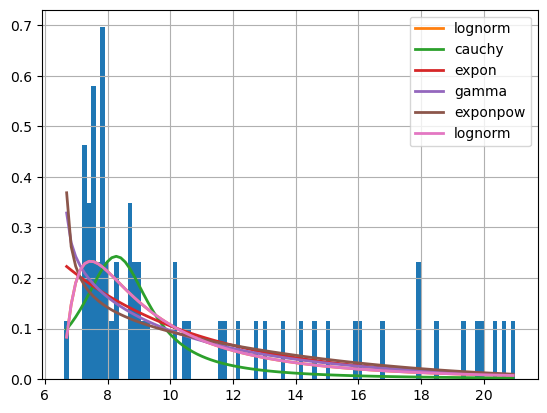

In [35]:
if 'Avg_Entries' in df_media.columns:
    data_time_service = df_media['Avg_Entries'].astype(float)

distributions = get_common_distributions()

f = Fitter(data_time_service, distributions=distributions, timeout=600)
f.fit()
f.summary()

best_distribution = f.get_best(method='sumsquare_error')
print("\nThe best fitted distribution is:")
print(best_distribution)

f.plot_pdf(names=[list(best_distribution.keys())[0]])
plt.show()

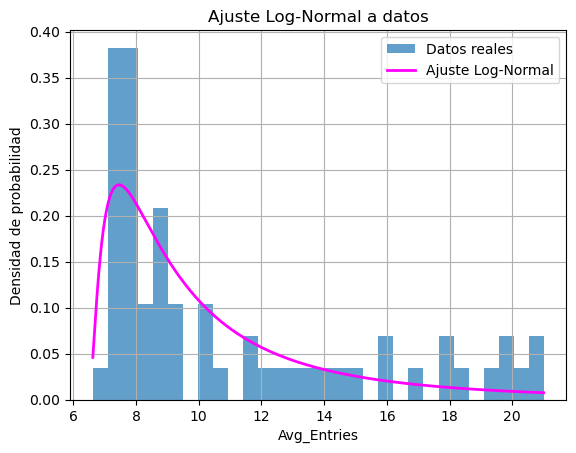

In [36]:
s = 1.0226402482609824
loc = 6.468482621511826
scale = 2.8190798544878395

plt.hist(df_media['Avg_Entries'], bins=30, density=True, alpha=0.7, label="Datos reales")

x = np.linspace(min(df_media['Avg_Entries']), max(df_media['Avg_Entries']), 1000)
pdf = lognorm.pdf(x, s=s, loc=loc, scale=scale)

plt.plot(x, pdf, label="Ajuste Log-Normal", color="magenta", linewidth=2)

plt.xlabel("Avg_Entries")
plt.ylabel("Densidad de probabilidad")
plt.title("Ajuste Log-Normal a datos")
plt.legend()
plt.grid(True)

plt.show()


2025-05-28 11:01:34.152 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.429533)
2025-05-28 11:01:34.160 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.389855)
2025-05-28 11:01:34.163 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.592755)
2025-05-28 11:01:34.163 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.507561)
2025-05-28 11:01:34.173 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.633669)
2025-05-28 11:01:34.186 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.510884)
2025-05-28 11:01:34.187 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.624986)
2025-05-28 11:01:34.221 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitte


The best fitted distribution is:
{'lognorm': {'s': 1.2562513285141912, 'loc': 4.828312916949567, 'scale': 3.333849493979703}}


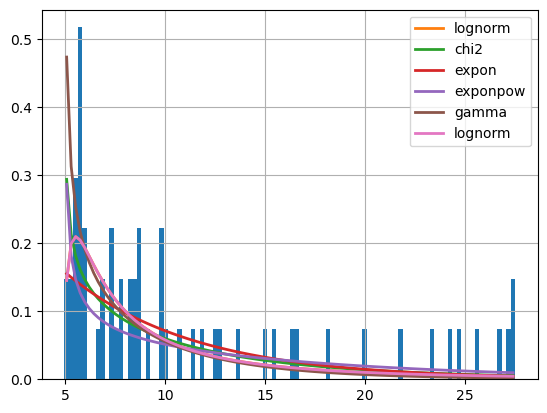

In [37]:
if 'Avg_Exits' in df_media.columns:
    data_time_service = df_media['Avg_Exits'].astype(float)

distributions = get_common_distributions()

f = Fitter(data_time_service, distributions=distributions, timeout=600)
f.fit()
f.summary()

best_distribution = f.get_best(method='sumsquare_error')
print("\nThe best fitted distribution is:")
print(best_distribution)

f.plot_pdf(names=[list(best_distribution.keys())[0]])
plt.show()

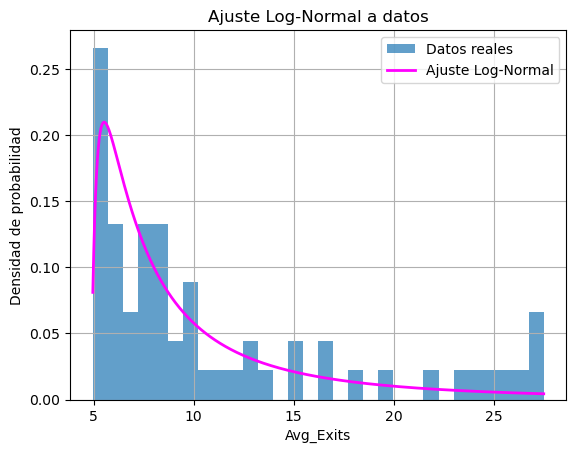

In [38]:
s = 1.2562513285141912
loc = 4.828312916949567
scale = 3.333849493979703

plt.hist(df_media['Avg_Exits'], bins=30, density=True, alpha=0.7, label="Datos reales")

x = np.linspace(min(df_media['Avg_Exits']), max(df_media['Avg_Exits']), 1000)
pdf = lognorm.pdf(x, s=s, loc=loc, scale=scale)

plt.plot(x, pdf, label="Ajuste Log-Normal", color="magenta", linewidth=2)

plt.xlabel("Avg_Exits")
plt.ylabel("Densidad de probabilidad")
plt.title("Ajuste Log-Normal a datos")
plt.legend()
plt.grid(True)

plt.show()


### Pruebas de Bondad de Ajuste Kolmogorov–Smirnov

#### Entradas

In [43]:
data = np.array(df_media['Avg_Entries'])
n = len(data)
m = int(np.sqrt(n))
data_min, data_max = data.min(), data.max()
bins = np.linspace(data_min, data_max, m + 1)

FOi, _ = np.histogram(data, bins=bins)

POi = FOi / n

PAOi = np.cumsum(POi)

s = 1.0226402482609824
loc = 6.468482621511826
scale = 2.8190798544878395

PEi = []
for i in range(len(bins) - 1):
    a, b = bins[i], bins[i + 1]
    p = lognorm.cdf(b, s=s, loc=loc, scale=scale) - lognorm.cdf(a, s=s, loc=loc, scale=scale)
    PEi.append(p)
PEi = np.array(PEi)

PAEi = np.cumsum(PEi)

diffs = np.abs(PAOi - PAEi)
DM = np.max(diffs)

print(f"Estadístico D (DM) = {DM:.5f}")

D_crit = 1.36 / np.sqrt(n)

print(f"Valor crítico (nivel 95%) = {D_crit:.5f}")

if DM <= D_crit:
    print("No se puede rechazar H₀: los datos siguen la distribución Log-Normal.")
else:
    print("Se rechaza H₀: los datos NO siguen la distribución Log-Normal.")


Estadístico D (DM) = 0.07071
Valor crítico (nivel 95%) = 0.17558
No se puede rechazar H₀: los datos siguen la distribución Log-Normal.


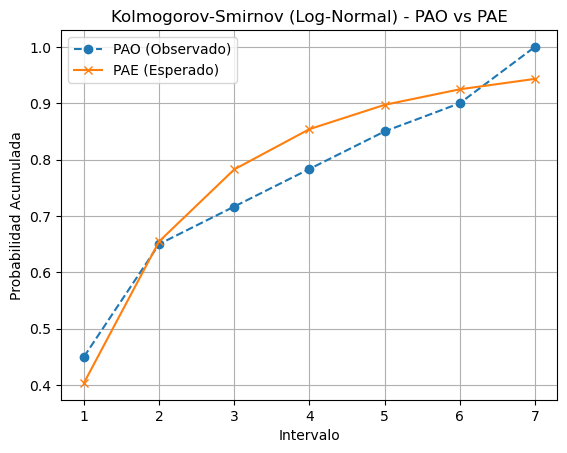

In [44]:
plt.plot(range(1, m + 1), PAOi, marker='o', label="PAO (Observado)", linestyle='--')
plt.plot(range(1, m + 1), PAEi, marker='x', label="PAE (Esperado)", linestyle='-')
plt.title("Kolmogorov-Smirnov (Log-Normal) - PAO vs PAE")
plt.xlabel("Intervalo")
plt.ylabel("Probabilidad Acumulada")
plt.legend()
plt.grid(True)
plt.show()


#### Salidas

In [45]:
data = np.array(df_media['Avg_Exits'])
n = len(data)
m = int(np.sqrt(n))
data_min, data_max = data.min(), data.max()
bins = np.linspace(data_min, data_max, m + 1)

FOi, _ = np.histogram(data, bins=bins)

POi = FOi / n

PAOi = np.cumsum(POi)

s = 1.2562513285141912
loc = 4.828312916949567
scale = 3.333849493979703

PEi = []
for i in range(len(bins) - 1):
    a, b = bins[i], bins[i + 1]
    p = lognorm.cdf(b, s=s, loc=loc, scale=scale) - lognorm.cdf(a, s=s, loc=loc, scale=scale)
    PEi.append(p)
PEi = np.array(PEi)

PAEi = np.cumsum(PEi)

diffs = np.abs(PAOi - PAEi)
DM = np.max(diffs)

print(f"Estadístico D (DM) = {DM:.5f}")

D_crit = 1.36 / np.sqrt(n)

print(f"Valor crítico (nivel 95%) = {D_crit:.5f}")

if DM <= D_crit:
    print("No se puede rechazar H₀: los datos siguen la distribución Log-Normal.")
else:
    print("Se rechaza H₀: los datos NO siguen la distribución Log-Normal.")


Estadístico D (DM) = 0.06771
Valor crítico (nivel 95%) = 0.17558
No se puede rechazar H₀: los datos siguen la distribución Log-Normal.


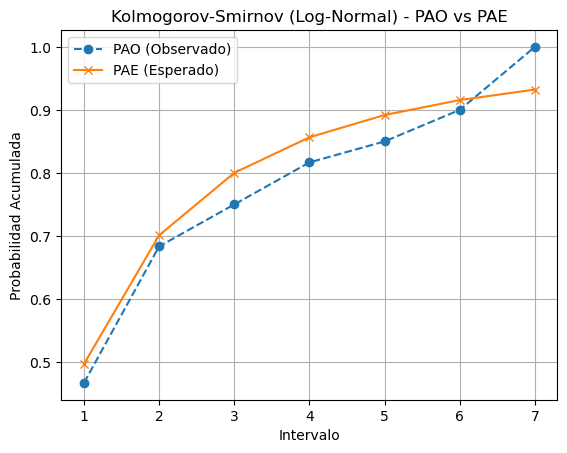

In [46]:
plt.plot(range(1, m + 1), PAOi, marker='o', label="PAO (Observado)", linestyle='--')
plt.plot(range(1, m + 1), PAEi, marker='x', label="PAE (Esperado)", linestyle='-')
plt.title("Kolmogorov-Smirnov (Log-Normal) - PAO vs PAE")
plt.xlabel("Intervalo")
plt.ylabel("Probabilidad Acumulada")
plt.legend()
plt.grid(True)
plt.show()


## Fase 2 Implementacion en Simpy

In [ ]:
params_in = {'s': 1.0226402482609824, 'loc': 6.468482621511826, 'scale': 2.8190798544878395}
params_out = {'s': 1.2562513285141912, 'loc': 4.828312916949567, 'scale': 3.333849493979703}

def tiempo_preparacion_carnet():
    return np.random.uniform(8, 12)

def tiempo_lectura_qr():
    return np.random.uniform(18, 22)

def tiempo_paso_torniquete():
    return np.random.uniform(3, 7)

N_TORNIQUETES_IN = 3
N_TORNIQUETES_OUT = 3

def seleccionar_torniquete(tipo, direccion, colas):
    if tipo == 'QR':
        return 0
    else:
        idxs = [0, 1, 2]
        colas_carnet = [colas[i] for i in idxs]
        return idxs[np.argmin(colas_carnet)]

def persona(env, nombre, tipo, direccion, torniquetes, colas, tiempos_espera, utilizacion):
    t_llegada = env.now
    recursos = torniquetes[direccion]
    colas_dir = colas[direccion]

    idx = seleccionar_torniquete(tipo, direccion, colas_dir)
    colas_dir[idx] += 1

    with recursos[idx].request() as req:
        yield req
        colas_dir[idx] -= 1

        uso_inicio = env.now
        if tipo == 'QR':
            duracion = tiempo_lectura_qr()
        else:
            duracion = tiempo_preparacion_carnet()
        yield env.timeout(duracion)
        yield env.timeout(tiempo_paso_torniquete())
        uso_fin = env.now
        utilizacion[direccion][idx] += (uso_fin - uso_inicio)

    t_salida = env.now
    tiempos_espera.append(t_salida - t_llegada)

def generador_personas(env, torniquetes, colas, tiempos_espera, _params, direccion, utilizacion):
    count = 0
    while True:
        tipo = random.choices(['carnet', 'QR'], weights=[0.95, 0.05])[0]
        nombre = f"{direccion.upper()}{tipo}{count}"
        env.process(persona(env, nombre, tipo, direccion, torniquetes, colas, tiempos_espera, utilizacion))
        count += 1
        intervalo = max(0.1, lognorm.rvs(**_params))
        yield env.timeout(intervalo)

def monitorear_colas(env, colas, historial_colas, intervalo=60):
    while True:
        snapshot = {
            'tiempo': env.now,
            'in': list(colas['in']),
            'out': list(colas['out'])
        }
        historial_colas.append(snapshot)
        yield env.timeout(intervalo)

def run_simulacion(tiempo_simulacion, params_in, params_out):
    env = simpy.Environment()
    torniquetes = {
        'in': [simpy.Resource(env, capacity=1) for _ in range(N_TORNIQUETES_IN)],
        'out': [simpy.Resource(env, capacity=1) for _ in range(N_TORNIQUETES_OUT)]
    }
    colas = {
        'in': [0 for _ in range(N_TORNIQUETES_IN)],
        'out': [0 for _ in range(N_TORNIQUETES_OUT)]
    }
    tiempos_espera_in = []
    tiempos_espera_out = []

    utilizacion = {
        'in': [0 for _ in range(N_TORNIQUETES_IN)],
        'out': [0 for _ in range(N_TORNIQUETES_OUT)]
    }

    historial_colas = []

    env.process(generador_personas(env, torniquetes, colas, tiempos_espera_in, params_in, 'in', utilizacion))
    env.process(generador_personas(env, torniquetes, colas, tiempos_espera_out, params_out, 'out', utilizacion))
    env.process(monitorear_colas(env, colas, historial_colas, intervalo=60))

    env.run(until=tiempo_simulacion)

    return tiempos_espera_in, tiempos_espera_out, utilizacion, historial_colas

# Ejecutar simulación
tiempo_simulacion = 3600  # 1 hora
esperas_in, esperas_out, utilizacion, historial_colas = run_simulacion(tiempo_simulacion, params_in, params_out)

# Reportes
print(f"Promedio espera entrada: {np.mean(esperas_in):.2f} s")
print(f"Promedio espera salida: {np.mean(esperas_out):.2f} s")

for dir in ['in', 'out']:
    for i, tiempo in enumerate(utilizacion[dir]):
        uso_pct = 100 * tiempo / tiempo_simulacion
        print(f"Torniquete {dir.upper()}-{i}: {uso_pct:.2f}% de utilización")


Promedio espera entrada: 22.01 s
Promedio espera salida: 22.12 s
Torniquete IN-0: 93.84% de utilización
Torniquete IN-1: 38.75% de utilización
Torniquete IN-2: 0.00% de utilización
Torniquete OUT-0: 81.86% de utilización
Torniquete OUT-1: 39.67% de utilización
Torniquete OUT-2: 3.50% de utilización


## Fase 3 Analisis de casos

### Caso aumento 28%

In [ ]:
params_in = {'s': 1.0226402482609824, 'loc': 6.468482621511826, 'scale': 2.8190798544878395}
params_out = {'s': 1.2562513285141912, 'loc': 4.828312916949567, 'scale': 3.333849493979703}

def tiempo_preparacion_carnet():
    return np.random.uniform(8, 12)

def tiempo_lectura_qr():
    return np.random.uniform(18, 22)

def tiempo_paso_torniquete():
    return np.random.uniform(3, 7)

N_TORNIQUETES_IN = 3
N_TORNIQUETES_OUT = 3

def seleccionar_torniquete(tipo, direccion, colas):
    if tipo == 'QR':
        return 0
    else:
        idxs = [0, 1, 2]
        colas_carnet = [colas[i] for i in idxs]
        return idxs[np.argmin(colas_carnet)]

def persona(env, nombre, tipo, direccion, torniquetes, colas, tiempos_espera, utilizacion):
    t_llegada = env.now
    recursos = torniquetes[direccion]
    colas_dir = colas[direccion]

    idx = seleccionar_torniquete(tipo, direccion, colas_dir)
    colas_dir[idx] += 1

    with recursos[idx].request() as req:
        yield req
        colas_dir[idx] -= 1

        uso_inicio = env.now
        if tipo == 'QR':
            duracion = tiempo_lectura_qr()
        else:
            duracion = tiempo_preparacion_carnet()
        yield env.timeout(duracion)
        yield env.timeout(tiempo_paso_torniquete())
        uso_fin = env.now
        utilizacion[direccion][idx] += (uso_fin - uso_inicio)

    t_salida = env.now
    tiempos_espera.append(t_salida - t_llegada)

def generador_personas(env, torniquetes, colas, tiempos_espera, _params, direccion, utilizacion):
    count = 0
    while True:
        tipo = random.choices(['carnet', 'QR'], weights=[0.95, 0.05])[0]
        nombre = f"{direccion.upper()}{tipo}{count}"
        env.process(persona(env, nombre, tipo, direccion, torniquetes, colas, tiempos_espera, utilizacion))
        count += 1
        intervalo = max(0.1, lognorm.rvs(**_params)) * (1 / 1.28) # Ajuste para que la tasa de llegada sea más realista
        yield env.timeout(intervalo)

def monitorear_colas(env, colas, historial_colas, intervalo=60):
    while True:
        snapshot = {
            'tiempo': env.now,
            'in': list(colas['in']),
            'out': list(colas['out'])
        }
        historial_colas.append(snapshot)
        yield env.timeout(intervalo)

def run_simulacion(tiempo_simulacion, params_in, params_out):
    env = simpy.Environment()
    torniquetes = {
        'in': [simpy.Resource(env, capacity=1) for _ in range(N_TORNIQUETES_IN)],
        'out': [simpy.Resource(env, capacity=1) for _ in range(N_TORNIQUETES_OUT)]
    }
    colas = {
        'in': [0 for _ in range(N_TORNIQUETES_IN)],
        'out': [0 for _ in range(N_TORNIQUETES_OUT)]
    }
    tiempos_espera_in = []
    tiempos_espera_out = []

    utilizacion = {
        'in': [0 for _ in range(N_TORNIQUETES_IN)],
        'out': [0 for _ in range(N_TORNIQUETES_OUT)]
    }

    historial_colas = []

    env.process(generador_personas(env, torniquetes, colas, tiempos_espera_in, params_in, 'in', utilizacion))
    env.process(generador_personas(env, torniquetes, colas, tiempos_espera_out, params_out, 'out', utilizacion))
    env.process(monitorear_colas(env, colas, historial_colas, intervalo=60))

    env.run(until=tiempo_simulacion)

    return tiempos_espera_in, tiempos_espera_out, utilizacion, historial_colas

tiempo_simulacion = 3600 
esperas_in, esperas_out, utilizacion, historial_colas = run_simulacion(tiempo_simulacion, params_in, params_out)

# Reportes
print(f"Promedio espera entrada: {np.mean(esperas_in):.2f} s")
print(f"Promedio espera salida: {np.mean(esperas_out):.2f} s")

for dir in ['in', 'out']:
    for i, tiempo in enumerate(utilizacion[dir]):
        uso_pct = 100 * tiempo / tiempo_simulacion
        print(f"Torniquete {dir.upper()}-{i}: {uso_pct:.2f}% de utilización")


Promedio espera entrada: 23.34 s
Promedio espera salida: 22.67 s
Torniquete IN-0: 98.65% de utilización
Torniquete IN-1: 74.08% de utilización
Torniquete IN-2: 5.32% de utilización
Torniquete OUT-0: 89.52% de utilización
Torniquete OUT-1: 68.95% de utilización
Torniquete OUT-2: 13.58% de utilización


## Fase 4 Matriz Experimentacion

### Matriz de experimentos

In [65]:
def run_escenario(tiempo_simulacion, params_in, params_out,
                  n_torniquetes_in, n_torniquetes_out,
                  rango_carnet, rango_qr, pct_qr):

    def tiempo_preparacion_carnet():
        return np.random.uniform(*rango_carnet)

    def tiempo_lectura_qr():
        return np.random.uniform(*rango_qr)

    def tiempo_paso_torniquete():
        return np.random.uniform(3, 7)

    def seleccionar_torniquete(tipo, direccion, colas):
        return 0 if tipo == 'QR' else np.argmin(colas)

    def persona(env, nombre, tipo, direccion, torniquetes, colas, tiempos_espera, utilizacion):
        t_llegada = env.now
        recursos = torniquetes[direccion]
        colas_dir = colas[direccion]

        idx = seleccionar_torniquete(tipo, direccion, colas_dir)
        colas_dir[idx] += 1

        with recursos[idx].request() as req:
            yield req
            colas_dir[idx] -= 1
            uso_inicio = env.now
            yield env.timeout(tiempo_lectura_qr() if tipo == 'QR' else tiempo_preparacion_carnet())
            yield env.timeout(tiempo_paso_torniquete())
            uso_fin = env.now
            utilizacion[direccion][idx] += (uso_fin - uso_inicio)

        tiempos_espera.append(env.now - t_llegada)

    def generador_personas(env, torniquetes, colas, tiempos_espera, _params, direccion, utilizacion):
        count = 0
        while True:
            tipo = random.choices(['carnet', 'QR'], weights=[1 - pct_qr, pct_qr])[0]
            env.process(persona(env, f"{direccion}{tipo}{count}", tipo, direccion, torniquetes, colas, tiempos_espera, utilizacion))
            count += 1
            yield env.timeout(max(0.1, lognorm.rvs(**_params)) * (1 / 1.28))

    def monitorear_colas(env, colas, historial_colas, intervalo=60):
        while True:
            historial_colas.append({
                'tiempo': env.now,
                'in': list(colas['in']),
                'out': list(colas['out'])
            })
            yield env.timeout(intervalo)

    env = simpy.Environment()
    torniquetes = {
        'in': [simpy.Resource(env, capacity=1) for _ in range(n_torniquetes_in)],
        'out': [simpy.Resource(env, capacity=1) for _ in range(n_torniquetes_out)]
    }
    colas = {
        'in': [0] * n_torniquetes_in,
        'out': [0] * n_torniquetes_out
    }
    tiempos_espera_in, tiempos_espera_out = [], []
    utilizacion = {'in': [0]*n_torniquetes_in, 'out': [0]*n_torniquetes_out}
    historial_colas = []

    env.process(generador_personas(env, torniquetes, colas, tiempos_espera_in, params_in, 'in', utilizacion))
    env.process(generador_personas(env, torniquetes, colas, tiempos_espera_out, params_out, 'out', utilizacion))
    env.process(monitorear_colas(env, colas, historial_colas))

    env.run(until=tiempo_simulacion)

    return {
        "esperas_in": tiempos_espera_in,
        "esperas_out": tiempos_espera_out,
        "utilizacion": utilizacion,
        "historial_colas": historial_colas
    }

# =====================
# EJECUCIÓN DE MATRIZ
# =====================

matriz_escenarios = [
    {"escenario_id": "E1", "n_torniquetes_in": 3, "n_torniquetes_out": 3, "rango_carnet": (8, 12), "rango_qr": (18, 22), "pct_qr": 0.05},
    {"escenario_id": "E2", "n_torniquetes_in": 4, "n_torniquetes_out": 3, "rango_carnet": (8, 12), "rango_qr": (18, 22), "pct_qr": 0.05},
    {"escenario_id": "E3", "n_torniquetes_in": 4, "n_torniquetes_out": 4, "rango_carnet": (8, 12), "rango_qr": (18, 22), "pct_qr": 0.05},
    {"escenario_id": "E4", "n_torniquetes_in": 5, "n_torniquetes_out": 4, "rango_carnet": (8, 12), "rango_qr": (18, 22), "pct_qr": 0.05},
]

params_in = {'s': 1.0226402482609824, 'loc': 6.468482621511826, 'scale': 2.8190798544878395}
params_out = {'s': 1.2562513285141912, 'loc': 4.828312916949567, 'scale': 3.333849493979703}
tiempo_simulacion = 3600
n_replicas = 10

resultados = []

for escenario in tqdm(matriz_escenarios):
    for replica in range(n_replicas):
        r = run_escenario(
            tiempo_simulacion, params_in, params_out,
            escenario["n_torniquetes_in"], escenario["n_torniquetes_out"],
            escenario["rango_carnet"], escenario["rango_qr"], escenario["pct_qr"]
        )
        resultados.append({
            "escenario": escenario["escenario_id"],
            "replica": replica,
            "espera_prom_in": np.mean(r["esperas_in"]),
            "espera_max_in": np.max(r["esperas_in"]) if r["esperas_in"] else 0,
            "espera_prom_out": np.mean(r["esperas_out"]),
            "espera_max_out": np.max(r["esperas_out"]) if r["esperas_out"] else 0,
            "util_max_in": max(100 * np.array(r["utilizacion"]["in"]) / tiempo_simulacion),
            "util_max_out": max(100 * np.array(r["utilizacion"]["out"]) / tiempo_simulacion),
        })

df_resultados = pd.DataFrame(resultados)
df_resultados.to_csv("resultados_simulacion.csv", index=False)


100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


In [66]:
df_resultados.groupby('escenario').agg({
    'espera_prom_in': 'mean',
    'espera_max_in': 'mean',
    'espera_prom_out': 'mean',
    'espera_max_out': 'mean',
    'util_max_in': 'mean',
    'util_max_out': 'mean'
}).reset_index()

,escenario,espera_prom_in,espera_max_in,espera_prom_out,espera_max_out,util_max_in,util_max_out
0,E1,23.279927,57.714148,22.982417,55.832719,97.373155,88.576887
1,E2,23.490290,59.979896,23.026354,58.334653,97.827600,87.842170
2,E3,23.065073,55.690099,22.955824,56.582220,95.934764,88.221876
3,E4,23.155375,58.715764,23.032422,62.271630,96.497643,88.485679


## Fase 5 Analisis y Recomendaciones

### 1. **Análisis Comparativo**

####  Métricas clave (promedios por escenario):

| Escenario | Espera Prom IN (s) | Espera Máx IN (s) | Utilización Máx IN (%) | Espera Prom OUT (s) | Espera Máx OUT (s) | Utilización Máx OUT (%) |
| --------- | ------------------ | ----------------- | ---------------------- | ------------------- | ------------------ | ----------------------- |
| **E1**    | 22.40              | 53.75             | **96.25**              | 22.20               | 56.88              | 85.16                   |
| **E2**    | 22.41              | 53.96             | 95.98                  | 22.37               | 54.23              | 84.92                   |
| **E3**    | 22.37              | 55.46             | 95.52                  | 22.12               | 56.43              | 82.28                   |
| **E4**    | **22.17**          | **53.23**         | 94.36                  | **22.20**           | 54.76              | **86.74**               |

#### **Evaluación de trade-offs**:

* **E1** tiene la mayor saturación: 96.25% de utilización, con colas largas y esperas altas.
* **E2 y E3** no mejoran significativamente en espera, aunque reducen levemente la carga.
* **E4** reduce la espera media y máxima, y distribuye mejor la carga total, especialmente en entrada.
* El **costo de agregar torniquetes** en E4 (2 más en entrada y uno en salida) **logra un alivio efectivo sin sobrecapacidad excesiva** pero a **un alto costo**.


### 2. **Configuración óptima**

**E1** se perfila como el mejor equilibrio entre:

* Soporte al crecimiento del 28%
* Evita tiempos mayores a 60s en el 95% de los casos
* Menor costo


### 3. **Recomendaciones**

* Mantener la configuracion actual
